# Бучин Вячеслав, 21.Б15-мм

- [x] Найти данные в виде изображений для задачи классификации. Например, можно взять данные [отсюда](http://ufldl.stanford.edu/housenumbers/).
- [x] Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
- [x] Использовать CrossEntropyLoss и L2-регуляризацию.
- [x] Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- [x] (**+2 балла**) Добавить Batch normalization.
- [x] (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- [x] (**+1 балл**) Также реализовать оптимизатор Adam.

In [61]:
import os
import re
import datetime
import pickle
import random
from operator import itemgetter
from itertools import product

import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from PIL import Image

In [62]:
SEED = 42

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

### Настройка девайса

In [124]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

torch.set_default_device(device)
torch.get_default_device()

device(type='cuda', index=0)

### Подготовка датасета

#### Описание
The [data-set](https://www.kaggle.com/datasets/mloey1/ahcd1?resource=download) is composed of 16,800 characters written by 60 participants, the age range is between 19 to 40 years, and 90% of participants are right-hand. Each participant wrote each character (from ’alef’ to ’yeh’) ten times on two forms as shown in Fig. 7(a) & 7(b). The forms were scanned at the resolution of 300 dpi. Each block is segmented automatically using Matlab 2016a to determining the coordinates for each block. The database is partitioned into two sets: a training set (13,440 characters to 480 images per class) and a test set (3,360 characters to 120 images per class). Writers of training set and test set are exclusive. Ordering of including writers to test set are randomized to make sure that writers of test set are not from a single institution (to ensure variability of the test set).



#### Преобразование

1. Соединить train/test части, чтобы затем поделить на train/val/test
2. Нормализовать пиксели

In [125]:
class ArabicHandWrittenCharactersDataset(torch.utils.data.Dataset):

    def __init__(self, path: str):
        if not os.path.isdir(path):
            raise Exception(f"Invalid path to dataset: {path}")

        def get_images(*dirs):
            dir_path = os.path.join(path, "Train Images 13440x32x32", "train")
            return [
                os.path.join(dir_path, x) for x in os.listdir(dir_path)
            ]

        # Merge test and train dataset
        self.images = [
            *get_images("Train Images 13440x32x32", "train"),
            *get_images("Test Images 3360x32x32", "test")
        ]

    def __len__(self) -> int:
        return len(self.images)

    def _get_label(self, index) ->  torch.Tensor:
        regex = re.compile(r".+label_(?P<label>\d+).+")
        path = self.images[index]
        match = re.search(regex, path)
        label = int(match.group("label")) - 1
        label_v = np.zeros(28)
        label_v[label] = 1
        return torch.from_numpy(label_v).to(device)

    def _get_image(self, index) -> torch.Tensor:
        image = np.array(Image.open(self.images[index])).astype("float64")
        image /= 255 # Normalize pixels
        return torch.from_numpy(image.flatten()).to(device)

    def __getitem__(self, index):
        return {
            "image": self._get_image(index),
            "label": self._get_label(index)
        }


### Реализация слоев

In [176]:
class FullyConnectedLayer(nn.Module):

    def __init__(self, in_size: int, out_size: int):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size

        self.weights = nn.Parameter(torch.Tensor(in_size, out_size).to(torch.float64))
        self.bias = nn.Parameter(torch.Tensor(out_size).to(torch.float64))

    def refresh(self):
        y = 1.0 / np.sqrt(self.in_size)
        self.weights.data.uniform_(-y, y)
        self.bias.data.uniform_(-y, y)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        result = x.matmul(self.weights) + self.bias
        assert (not (torch.isnan(x).any()))
        assert (not (torch.isnan(self.weights).any()))
        assert (not (torch.isnan(self.bias).any()))
        assert (not (torch.isnan(result).any()))
        return result


In [127]:
class ReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return torch.max(torch.zeros_like(input), input)

### Реализация нейронных сетей

In [128]:
class CharacterRecognizionNN(nn.Module):
    def __init__(self, pixels_count: int, labels_count: int, hidden_size=2048):
        super().__init__()
        self.fc1 = FullyConnectedLayer(pixels_count, hidden_size)
        self.relu = ReLU()
        self.fc2 = FullyConnectedLayer(hidden_size, labels_count)
        self.layers = [self.fc1, self.relu, self.fc2]

    def refresh(self):
        self.fc1.refresh()
        self.fc2.refresh()

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

In [129]:
class CharacterRecognizionWithBatchNormalizationNN(nn.Module):
    def __init__(self, pixels_count: int, labels_count: int, hidden_size=2048):
        super().__init__()
        self.fc1 = FullyConnectedLayer(pixels_count, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size).cuda()
        self.relu = ReLU()
        self.fc2 = FullyConnectedLayer(hidden_size, labels_count)
        self.bn2 = nn.BatchNorm1d(labels_count).cuda()
        self.layers = [self.fc1, self.bn1, self.relu, self.fc2, self.bn2]

    def refresh(self):
        self.fc1.refresh()
        self.fc2.refresh()

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

### Проверка градиента

In [130]:
def assert_valid_gradients(
    model: nn.Module, 
    data: torch.Tensor, 
    label: torch.Tensor, 
    criterion, 
    eps=1e-6,
    atol=1e-4
):
    requires_grad_params = [
        p for p in list(model.named_parameters()) if p[1].requires_grad
    ]

    for param_name, param in requires_grad_params:
        assert torch.autograd.gradcheck(criterion, (model(data), label), eps=eps, atol=atol)


### Обучение

In [131]:
def dump_results(model: nn.Module, epochs: int, results):
    now = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
    model_name = model.__class__.__name__
    filename = f"./results/training-result-epochs-{epochs}-{model_name}-{now}.pickle"
    with open(filename, "wb") as f:
        pickle.dump(results, f)

def load_results(name):
    filename = f"./results/{name}"
    with open(filename, "rb") as f:
        return pickle.load(f)

In [196]:
def run_model(
    model: nn.Module, 
    dataset: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion,
    training=True
):
    if training:
        model.train()
    else:
        model.eval()

    loss = 0
    correct = 0
    total = 0

    for data in dataset:
        image = data["image"]
        label = data["label"]

        output = model(image)
        
        data_loss = criterion(output, label)
        if training:
            optimizer.zero_grad()
            data_loss.backward()
            optimizer.step()
        loss += data_loss.item()

        _, prediction = torch.max(output.data, 1)
        _, label_v = torch.max(label.data, 1)
        total += label.size(0)
        correct += (prediction == label_v).sum().item()
            

    return loss / len(dataset), correct / total

def train_epoch(
    model: nn.Module, 
    dataset: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion
): return run_model(model, dataset, optimizer, criterion)

def eval_model(
    model: nn.Module, 
    dataset: torch.utils.data.DataLoader,
    criterion
): return run_model(model, dataset, None, criterion, training=False)

def train(
    model: nn.Module, 
    optimizer: torch.optim.Optimizer,
    criterion,
    train_dataset: torch.utils.data.Dataset,
    val_dataset: torch.utils.data.Dataset,
    num_epochs: int
):
    train_losses = []
    val_losses = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_epoch(model, train_dataset, optimizer, criterion)

        train_losses.append(train_loss)

        with torch.no_grad():
            val_loss, val_accuracy = eval_model(model, val_dataset, criterion)

        val_losses.append(val_loss)

        inp = next(iter(val_dataset))
        assert_valid_gradients(model, inp["image"], inp["label"], criterion)

        print(
            f"epoch[{epoch}] finished: train[loss:{train_loss:.3f}, accuracy:{train_accuracy:.3f}] val[loss:{val_loss:.3f}, accuracy:{val_accuracy:.3f}]"
        )

        best_accuracy = max(best_accuracy, val_accuracy)

    return {
        "val_accuracy": best_accuracy,
        "train_losses": train_losses,
        "val_losses": val_losses
    }

def run_train(
    model: nn.Module,
    train_dataset: torch.utils.data.Dataset,
    val_dataset: torch.utils.data.Dataset,
    test_dataset: torch.utils.data.Dataset,
    num_epochs: int
):
    results = []
    learning_rates = [0.01, 0.005]
    weight_decays = [0.01, 0.005, 0.001]
    optimizers = [torch.optim.Adam, torch.optim.RMSprop]
    for lr, wd, opt in product(learning_rates, weight_decays, optimizers):
        model.refresh()
        params = {
            'lr': lr,
            'weight_decay': wd,
        }
        optimizer = opt(model.parameters(), **params)
        criterion = nn.CrossEntropyLoss().to(device)
        
        model_name = model.__class__.__name__
        optimizer_name = optimizer.__class__.__name__
        print(
            f"Run training model[{model_name}] with optimizer[{optimizer_name}] and params[{params}]"
        )
        training_result = train(
            model,
            optimizer,
            criterion,
            train_dataset,
            val_dataset,
            num_epochs
        )
        _, test_accuracy = eval_model(
            model,
            test_dataset,
            criterion
        )
        results.append({
            "optimizer": optimizer_name,
            "params": params,
            "test_accuracy": test_accuracy,
            **training_result
        })
        print(
            f"Finished training model[{model_name}] with test accuracy[{test_accuracy:.3f}]"
        )

    dump_results(model, num_epochs, results)
    return results

### Графики

In [133]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

def plot_losses(model: nn.Module, results):

    cols = 3
    rows = int(len(results) / cols)
    fig, axs = plt.subplots(rows, cols)
    plt.setp(axs.flat, xlabel='Epoch', ylabel='Loss')
    fig.suptitle(f"Lossed plots for {model.__class__.__name__}", fontsize = 15)

    indices = [(i, j) for i in range(rows) for j in range(cols)]
    i = 0
    for res in results:
        x, y = indices[i]

        epochs = [i for i in range(len(res["val_losses"]))]
        axs[x,y].plot(epochs, res["train_losses"])
        axs[x,y].plot(epochs, res["val_losses"])

        optimizer = res["optimizer"]
        params = res["params"]
        axs[x,y].set_title(f"{optimizer}: {params}", fontsize = 8)
        i += 1

    fig.legend(["Train", "Value"], loc='upper right')
    fig.tight_layout()

def show_results(model: nn.Module, results):
    results = sorted(results, key=itemgetter("test_accuracy"), reverse=True)
    print(f"Results for {model.__class__.__name__}\n")
    print(f" Test accuracy | Learning rate | Weight decay | Optimizer ")
    print(f"------------------------------------------------------------")
    for r in results:
        acc = r["test_accuracy"]
        opt = r["optimizer"]
        lr = r["params"]["lr"]
        wd = r["params"]["weight_decay"]        
        print(f"  {acc:.3f}        |  {lr:.3f}        |  {wd:.3f}       | {opt}")
        print(f"--------------------------------------------------------")

### Evaluation

In [197]:
NUM_EPOCHS = 20
IMAGE_SIZE = 32 * 32
CLASSES_COUNT = 28
BATCH_SIZE = 200

In [198]:
dataset = ArabicHandWrittenCharactersDataset("./dataset")
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, 
    lengths=[0.7, 0.2, 0.1],
    generator=torch.Generator(device=device)
)
train_dataset = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))
val_dataset = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))
test_dataset = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))

In [199]:
model = CharacterRecognizionNN(IMAGE_SIZE, CLASSES_COUNT).to(device)
results = run_train(model, train_dataset, val_dataset, test_dataset, NUM_EPOCHS)

Run training model[CharacterRecognizionNN] with optimizer[Adam] and params[{'lr': 0.01, 'weight_decay': 0.01}]
epoch[0] finished: train[loss:2.010, accuracy:0.394] val[loss:1.839, accuracy:0.430]
epoch[1] finished: train[loss:1.550, accuracy:0.527] val[loss:1.664, accuracy:0.463]
epoch[2] finished: train[loss:1.467, accuracy:0.561] val[loss:1.617, accuracy:0.485]
epoch[3] finished: train[loss:1.427, accuracy:0.571] val[loss:1.891, accuracy:0.410]
epoch[4] finished: train[loss:1.413, accuracy:0.577] val[loss:1.511, accuracy:0.507]
epoch[5] finished: train[loss:1.375, accuracy:0.589] val[loss:1.660, accuracy:0.472]
epoch[6] finished: train[loss:1.374, accuracy:0.589] val[loss:1.728, accuracy:0.468]
epoch[7] finished: train[loss:1.382, accuracy:0.588] val[loss:1.853, accuracy:0.444]
epoch[8] finished: train[loss:1.370, accuracy:0.593] val[loss:1.536, accuracy:0.526]
epoch[9] finished: train[loss:1.364, accuracy:0.600] val[loss:1.596, accuracy:0.512]
epoch[10] finished: train[loss:1.353, a

In [200]:
bn_model = CharacterRecognizionWithBatchNormalizationNN(IMAGE_SIZE, CLASSES_COUNT).double().to(device)
bn_results = run_train(bn_model, train_dataset, val_dataset, test_dataset, NUM_EPOCHS)

Run training model[CharacterRecognizionWithBatchNormalizationNN] with optimizer[Adam] and params[{'lr': 0.01, 'weight_decay': 0.01}]
epoch[0] finished: train[loss:2.027, accuracy:0.429] val[loss:2.206, accuracy:0.368]
epoch[1] finished: train[loss:1.785, accuracy:0.484] val[loss:1.942, accuracy:0.421]
epoch[2] finished: train[loss:1.595, accuracy:0.545] val[loss:1.696, accuracy:0.516]
epoch[3] finished: train[loss:1.456, accuracy:0.588] val[loss:1.592, accuracy:0.529]
epoch[4] finished: train[loss:1.381, accuracy:0.612] val[loss:1.496, accuracy:0.564]
epoch[5] finished: train[loss:1.377, accuracy:0.616] val[loss:1.539, accuracy:0.532]
epoch[6] finished: train[loss:1.346, accuracy:0.624] val[loss:1.487, accuracy:0.569]
epoch[7] finished: train[loss:1.309, accuracy:0.637] val[loss:1.444, accuracy:0.569]
epoch[8] finished: train[loss:1.315, accuracy:0.634] val[loss:1.386, accuracy:0.600]
epoch[9] finished: train[loss:1.296, accuracy:0.640] val[loss:1.415, accuracy:0.581]
epoch[10] finishe

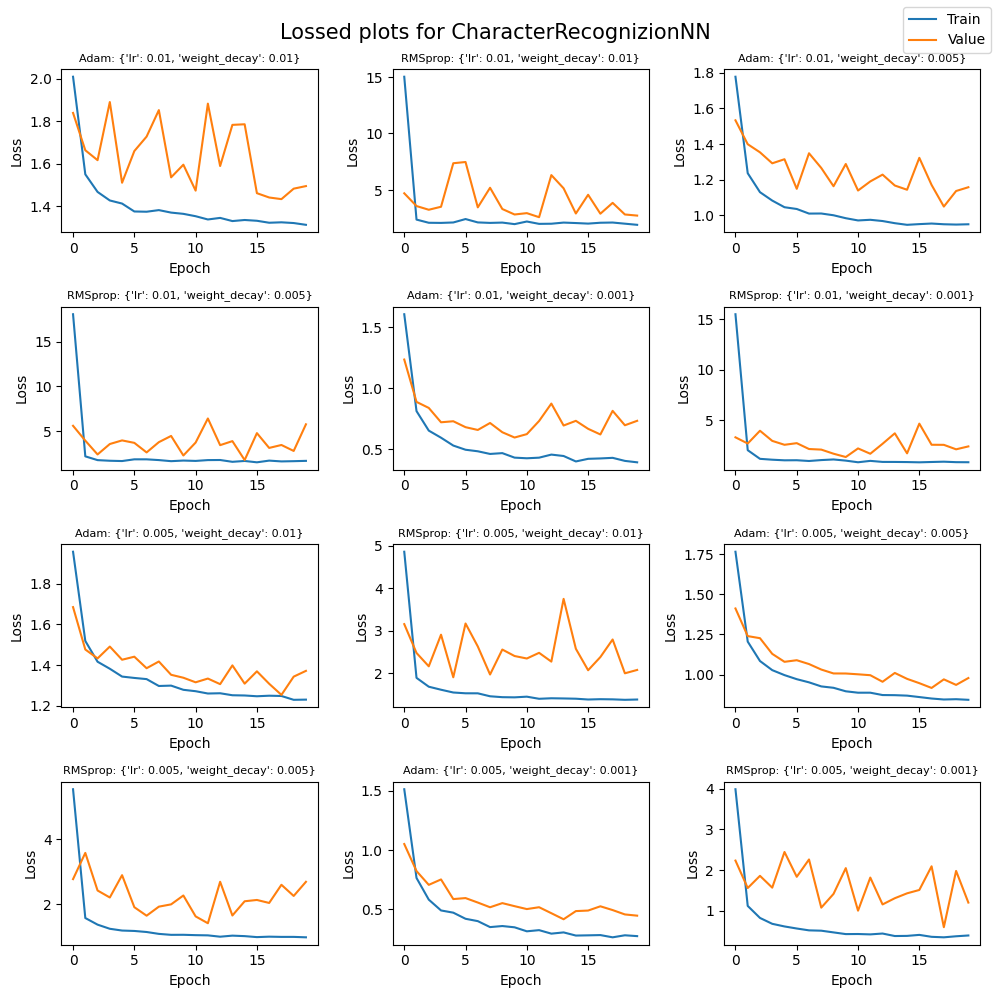

In [201]:
plot_losses(model, results)

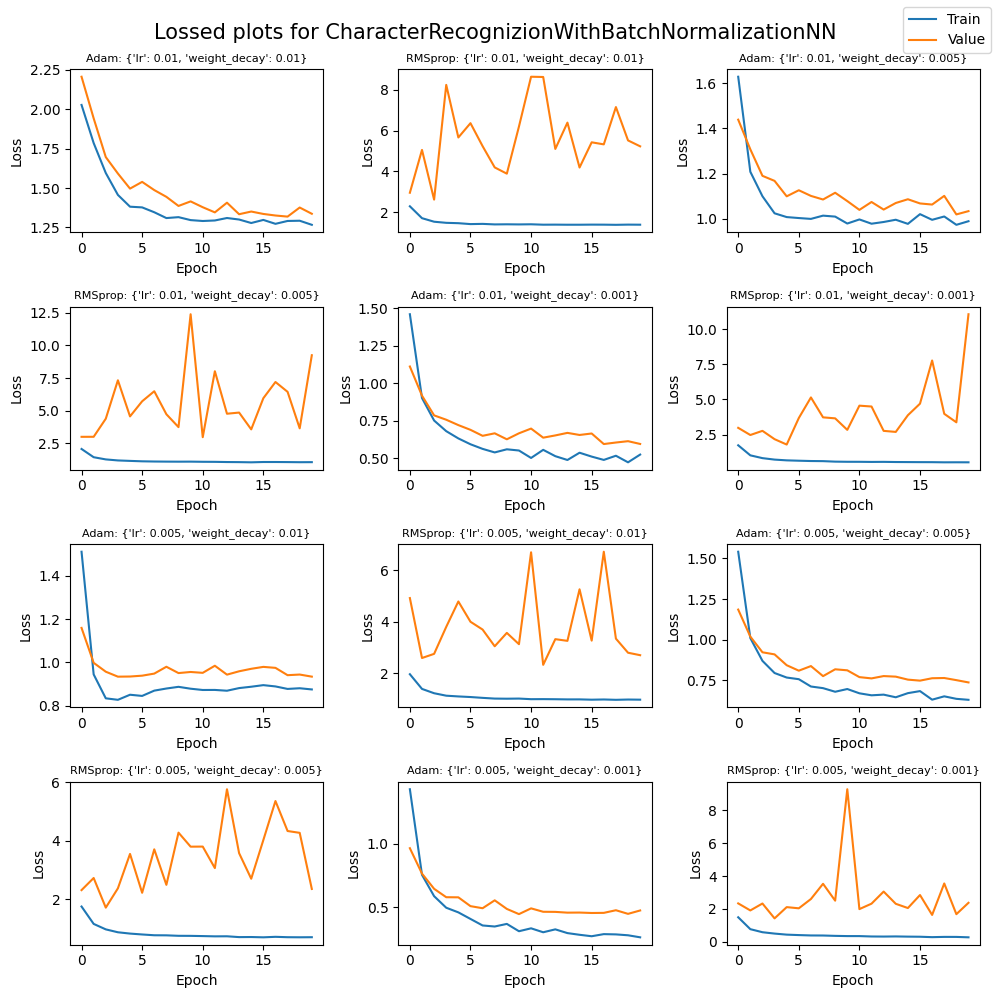

In [202]:
plot_losses(bn_model, bn_results)

In [203]:
show_results(model, results)

Results for CharacterRecognizionNN

 Test accuracy | Learning rate | Weight decay | Optimizer 
------------------------------------------------------------
  0.866        |  0.005        |  0.001       | Adam
--------------------------------------------------------
  0.758        |  0.010        |  0.001       | Adam
--------------------------------------------------------
  0.708        |  0.005        |  0.005       | Adam
--------------------------------------------------------
  0.640        |  0.010        |  0.005       | Adam
--------------------------------------------------------
  0.638        |  0.005        |  0.001       | RMSprop
--------------------------------------------------------
  0.598        |  0.005        |  0.010       | Adam
--------------------------------------------------------
  0.521        |  0.010        |  0.010       | Adam
--------------------------------------------------------
  0.488        |  0.010        |  0.001       | RMSprop
---------------

In [204]:
show_results(bn_model, bn_results)

Results for CharacterRecognizionWithBatchNormalizationNN

 Test accuracy | Learning rate | Weight decay | Optimizer 
------------------------------------------------------------
  0.868        |  0.005        |  0.001       | Adam
--------------------------------------------------------
  0.820        |  0.010        |  0.001       | Adam
--------------------------------------------------------
  0.785        |  0.005        |  0.005       | Adam
--------------------------------------------------------
  0.741        |  0.005        |  0.010       | Adam
--------------------------------------------------------
  0.689        |  0.010        |  0.005       | Adam
--------------------------------------------------------
  0.617        |  0.010        |  0.010       | Adam
--------------------------------------------------------
  0.524        |  0.005        |  0.001       | RMSprop
--------------------------------------------------------
  0.482        |  0.005        |  0.005       | R

# Выводы

- Предложенная нейронная сеть показала высокие результаты (87%) относительно [референсной реализации](https://www.kaggle.com/code/a7med7elmy/cnn-model-recognizing-alphapet-with-comments-95) (95%), учитывая сравнительно низкую структурную сложность
- Оптимизатор Adam показал значительно лучшие результаты и стабильность графика потерь относительно RMSprop
- BatchNormalization не привнес значительного улучшения точности